In [128]:
# feature encoder
#安裝函式庫編碼器
!pip install -q category_encoders

In [129]:
#安裝兩種函式庫，用於處理不平衡數據集
#-q安靜地安裝,-U如果已經安裝就更新到新版
!pip install -q -U imblearn
!pip install -q -U imbalanced-learn

In [130]:
#安裝三種函式庫
#xgboost 是一個基於樹模型的機器學習函式庫，提供高效率和高性能的機器學習模型。它支持並行和分佈式運算，可以處理大規模數據集。
#lightgbm 是一個基於樹模型的機器學習函式庫，提供高效率和高性能的機器學習模型。它支持並行和分佈式運算，可以處理大規模數據集。
#catboost 是一個基於樹模型的機器學習函式庫，支持分類和迴歸任務。它支持並行和分佈式運算，可以處理大規模數據集。
!pip install -U -q xgboost lightgbm catboost

In [131]:
#導入pandas並命名為pd
#從剛剛那些下載的安裝包裡面導入所需函數
import pandas as pd
from sklearn.model_selection import train_test_split

import gc
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy import stats
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import category_encoders as ce

from collections import Counter
from imblearn.over_sampling import SMOTE


import pickle
import seaborn as sns

import itertools

import warnings
warnings.filterwarnings("ignore")

In [132]:
#連線到我的雲端硬碟
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [133]:
#讀取我雲端硬碟中的這個檔案
#把這個資料命名成df
data= '/content/gdrive/MyDrive/2023/2023-2-Python-AI/data/archive.zip'
df=pd.read_csv(data)

In [134]:
#顯示頭兩筆資料
df.head(2)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [135]:
#info,檔案資訊
#10種欄位是數字,2種欄位是文字
#目標是找出客戶流失率
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [136]:
#isnull,是空的嗎?如果為真sum,總和給我
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

# **下面都在檢查流失率,從多個角度**

In [137]:
# rate of churn; too low to take care
# only 20 % in churm
#在churn這個欄位,用mean平均數來找出流失率,2037/10000

df[['churn']].mean()

churn    0.2037
dtype: float64

In [138]:
# churn indepement of one's gender
#groupby群組gender性別aggregate彙總churn流失率
df.groupby("gender").agg({"churn": ["mean","count"]})

churn      
            mean count
gender                
Female  0.250715  4543
Male    0.164559  5457

In [139]:
# churn rate of Germany is igher than others
#groupby群組country國家aggregate彙總churn流失率
df.groupby("country").agg({"churn": ["mean","count"]})

churn      
             mean count
country                
France   0.161548  5014
Germany  0.324432  2509
Spain    0.166734  2477

In [140]:
#  churn rate indepent of whether owns creredict card
#流失率與信用卡有關嗎
df.groupby("credit_card").agg({"churn": ["mean","count"]})

churn      
                 mean count
credit_card                
0            0.208149  2945
1            0.201843  7055

In [141]:
# churn rate is lower if one registered from activity
#註冊會員有更低的流失率
df.groupby("active_member").agg({"churn": ["mean","count"]})


churn      
                   mean count
active_member                
0              0.268509  4849
1              0.142691  5151

In [142]:
# the more one purchased, the more one is in churn state
#買越多產品客戶流失率越高
df.groupby("products_number").agg({"churn": ["mean","count"]})

churn      
                     mean count
products_number                
1                0.277144  5084
2                0.075817  4590
3                0.827068   266
4                1.000000    60

In [143]:
# no info?

df.groupby("tenure").agg({"churn": ["mean","count"]})

churn      
            mean count
tenure                
0       0.230024   413
1       0.224155  1035
2       0.191794  1048
3       0.211100  1009
4       0.205258   989
5       0.206522  1012
6       0.202689   967
7       0.172179  1028
8       0.192195  1025
9       0.216463   984
10      0.206122   490

# **找出特徵種類**

In [144]:
#將我們要找到的target目標變數設定為churn流失率
#categorical_variables列表生成式
#不同值要小於10確保該欄位不是目標變數churn
#滿足這任一條件就加入列表

target= 'churn'
categorical_variables = [col for col in df if col in "O"
                         or df[col].nunique() <=10
                         and col not in target]
print("Categorical Features: ",categorical_variables)

Categorical Features:  ['country', 'gender', 'products_number', 'credit_card', 'active_member']


In [145]:
#numeric_variables列表式生成
#是否有object非數值欄位
#是否大於5
#滿足任一條件加入列表

numeric_variables = [col for col in df.columns if df[col].dtype != "object"
                        and df[col].nunique() >5]
print("Numerical Features: ",numeric_variables)

Numerical Features:  ['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'estimated_salary']


In [146]:
#計算不同個數的種類
#國家三種,性別兩種,產品數量4種,會員非會員兩種,有無信用卡兩種,流失或未流失兩種
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

# **簡單畫個圖**

In [147]:
# observe the numeric fertures what they are distributed, whether are instributed in Normal (Gaussian)
# visualize kde density plot and check whether in Gaussian
def kde_QQ_vis(df, cols):
    sns.set_style('whitegrid')
    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(10, 3 * len(cols)))
    for i, col in enumerate(cols):
        # Histogram for the column
        sns.histplot(df[col], kde=True, ax=axes[i][0], color='red', edgecolor='black')
        axes[i][0].set_title(f'Histogram of {col}', fontsize=12)
        axes[i][0].set_xlabel('')
        axes[i][0].set_ylabel('Density')

        # Q-Q plot for the column
        stats.probplot(df[col], dist="norm", plot=axes[i][1])
        axes[i][1].set_title(f'Q-Q Plot of {col}', fontsize=12)
        axes[i][1].set_xlabel('Theoretical Quantiles')
        axes[i][1].set_ylabel('Ordered Values')
        axes[i][1].get_lines()[0].set_color('blue')
        axes[i][1].get_lines()[1].set_color('red')
    # Adjust the layout
    plt.tight_layout()

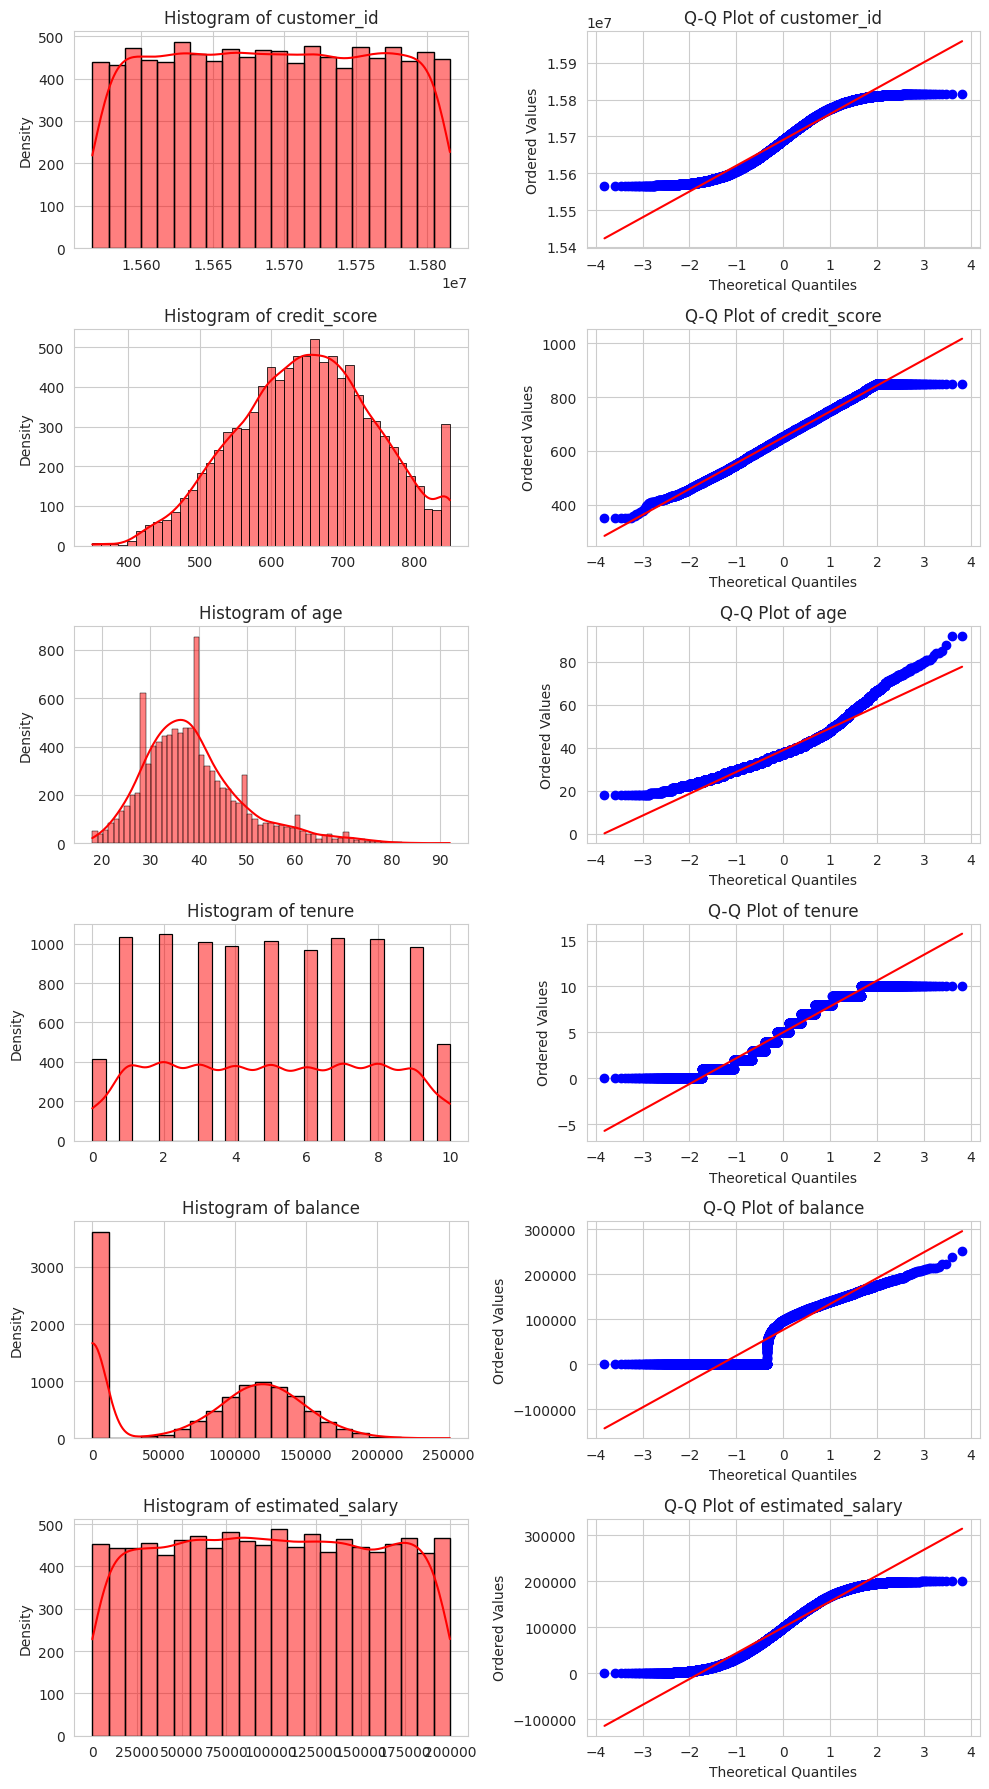

In [148]:
# check 'credit_score', 'balance', 'estimated_salary'
kde_QQ_vis(df, numeric_variables)

# **數據標準化的過程**

Conclusion
---
The features, <b>`tenue`</b> and <b>`estimated_salary`</B>, are not distributed absolutely in Gaussian obviously!

Data normalized
---
Nonamized data do help to modeling; different type
 different conversion:
 1. sklearn.preprocessing.StandardScaler: Data in normal.
 $$\bar X_i=\frac{X_i-EX}{\sigma (X)}\sim N(0,1)$$
 2. sklearn.preprocessing.MinMaxScaler: Data in abnomal
 $$ \bar X_i=\frac{X_i-X_\min}{X_\max-X_\min}\sim U(0,1)$$

In [149]:
#把上面的公式導入
def StandardScaler(df,cols):
    for col in cols:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df
def NormalizationScaler(df,cols):
    for col in cols:
        df[col] = (df[col] - df[col].min()) / (df[col] .max()- df[col].min())
    return df

However numeric_variables[0]= `customer_id` redudent, each one owning unique one, give up.

In [150]:
# data saved
#存檔
saved='/content/gdrive/MyDrive/2023/2023-2-Python-AI/data/churn-data20240525.csv'
df.to_csv(saved,index=False)

Data Washing, (Feature Engineer)
---
There are some packages that automatical do `Feature Engineering` work, suchas
- [Featuretools](https://github.com/alteryx/featuretools),
- [sklearn](https://scikit-learn.org/stable/)
```python
from sklearn.feature_selection import f_regression
scores, _ = f_regression(df.iloc[:,0:2], df.iloc[:,-1])
print(scores)
```
- [Feature-engine](https://feature-engine.trainindata.com/en/latest/)

Here, we manually do these works:

a). delete redundant features,`customer_id`<br>
b).

In [151]:
#導入這個資料並開始做,初始化從這裡開始
df = pd.read_csv('/content/gdrive/MyDrive/2023/2023-2-Python-AI/data/churn-data20240525.csv')

In [152]:
# drop un-required features

#刪掉一個欄位,
def clean_data20240525(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop columns:  'customer_id',
    df.drop(columns=['customer_id'], inplace=True)
    return df

df_clean = clean_data20240525(df)

In [153]:
df_clean.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [154]:
# sklean example
# H0: the regression coefficient is equal to zero.
# i.e. non-implantant freture to be used to predictctarget

from sklearn.feature_selection import f_regression
scores, p_vals = f_regression(df.iloc[:,4:9], df.iloc[:,-1])
# Print the feature names and scores
for i, score in enumerate(scores):
    print(f"Feature {i+4}: {df.columns[i+4]} - Score: {score:.3f}, with p-value: {p_vals[i]:.2f}")

Feature 4: tenure - Score: 1.960, with p-value: 0.16
Feature 5: balance - Score: 142.474, with p-value: 0.00
Feature 6: products_number - Score: 22.915, with p-value: 0.00
Feature 7: credit_card - Score: 0.509, with p-value: 0.48
Feature 8: active_member - Score: 249.801, with p-value: 0.00


In [155]:
# Feature Engineering
# binning the data
#把重複性低的資料分箱,計算並新增一些欄位
#新增Tenure=tenure/age
#新增Tenure_add_age=tenure+age
#新增Tenure_minus_age=tenure-age
#新增Tenure_times_age=tenure*age
df_clean["CreditsScore"] = pd.qcut(df_clean['credit_score'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["Age"] = pd.qcut(df_clean['age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["Balance"] = pd.qcut(df_clean['balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["EstSalary"] = pd.qcut(df_clean['estimated_salary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df_clean["Tenure"] = df_clean["tenure"]/df_clean["age"]
df_clean["Tenure_add_age"] = df_clean["tenure"]+df_clean["age"]
df_clean["Tenure_minus_age"] = df_clean["tenure"]-df_clean["age"]
df_clean["Tenure_times_age"] = df_clean["tenure"]*df_clean["age"]
df_clean.dtypes

credit_score           int64
country               object
gender                object
age                    int64
tenure                 int64
balance              float64
products_number        int64
credit_card            int64
active_member          int64
estimated_salary     float64
churn                  int64
CreditsScore        category
Age                 category
Balance             category
EstSalary           category
Tenure               float64
Tenure_add_age         int64
Tenure_minus_age       int64
Tenure_times_age       int64
dtype: object

In [156]:
#  data

y_clean = df_clean[target]
df_clean = df_clean.drop(target,axis=1)

In [157]:
df_clean.dtypes

credit_score           int64
country               object
gender                object
age                    int64
tenure                 int64
balance              float64
products_number        int64
credit_card            int64
active_member          int64
estimated_salary     float64
CreditsScore        category
Age                 category
Balance             category
EstSalary           category
Tenure               float64
Tenure_add_age         int64
Tenure_minus_age       int64
Tenure_times_age       int64
dtype: object

In [158]:
df_clean.nunique()

credit_score         460
country                3
gender                 2
age                   70
tenure                11
balance             6382
products_number        4
credit_card            2
active_member          2
estimated_salary    9999
CreditsScore           6
Age                    8
Balance                5
EstSalary             10
Tenure               414
Tenure_add_age        75
Tenure_minus_age      75
Tenure_times_age     363
dtype: int64

In [159]:
# Binary Feature value;
# convert the last four categorical features to numeric ones
#把CreditsScore,Age,Balance轉化成整數型
#把EstSalary轉化成浮點數型
features_=['CreditsScore','Age','Balance']
for f_ in features_:
    df_clean[f_] = df_clean[f_].astype(int)

df_clean['EstSalary'] = df_clean['EstSalary'].astype(float)

In [160]:
df_clean.dtypes

credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
CreditsScore          int64
Age                   int64
Balance               int64
EstSalary           float64
Tenure              float64
Tenure_add_age        int64
Tenure_minus_age      int64
Tenure_times_age      int64
dtype: object

In [161]:
# prompt: delete pandas column

#df_clean.drop(columns=['age','tenure','balance','estimated_salary'],axis=1,inplace=True)

# **用剛剛定義過的公式把數據標準化**

Nornamize data
---

In [162]:
df_clean=StandardScaler(df_clean,['age','balance','estimated_salary'])

In [163]:
df_clean= NormalizationScaler(df_clean,['tenure'])

In [164]:
df_clean.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,CreditsScore,Age,Balance,EstSalary,Tenure,Tenure_add_age,Tenure_minus_age,Tenure_times_age
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,3,6,1,6.0,0.047619,44,-40,84
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,2,6,3,6.0,0.024390,42,-40,41


In [165]:
df_clean.dtypes

credit_score          int64
country              object
gender               object
age                 float64
tenure              float64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
CreditsScore          int64
Age                   int64
Balance               int64
EstSalary           float64
Tenure              float64
Tenure_add_age        int64
Tenure_minus_age      int64
Tenure_times_age      int64
dtype: object

In [166]:
# combine features,string feafures only
# 組合特徵，僅字串特徵
def feature_bind(df,col1,col2):
    df[col1+'_'+col2]=df[col1].astype(str)+df[col2].astype(str)
    return df

In [167]:
df_clean =  feature_bind(df_clean,'country','gender')
df_clean =  feature_bind(df_clean,'country','products_number')
df_clean =  feature_bind(df_clean,'country','Age')

In [168]:
df_clean.dtypes

credit_score                 int64
country                     object
gender                      object
age                        float64
tenure                     float64
balance                    float64
products_number              int64
credit_card                  int64
active_member                int64
estimated_salary           float64
CreditsScore                 int64
Age                          int64
Balance                      int64
EstSalary                  float64
Tenure                     float64
Tenure_add_age               int64
Tenure_minus_age             int64
Tenure_times_age             int64
country_gender              object
country_products_number     object
country_Age                 object
dtype: object

In [169]:
# database diveded

y = y_clean
X = df_clean


In [170]:
X.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,Age,Balance,EstSalary,Tenure,Tenure_add_age,Tenure_minus_age,Tenure_times_age,country_gender,country_products_number,country_Age
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,6,1,6.0,0.047619,44,-40,84,FranceFemale,France1,France6
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,6,3,6.0,0.024390,42,-40,41,SpainFemale,Spain1,Spain6
2,502,France,Female,0.293503,0.8,1.332987,3,1,0,0.240675,...,6,5,6.0,0.190476,50,-34,336,FranceFemale,France3,France6
3,699,France,Female,0.007456,0.1,-1.225786,2,0,0,-0.108912,...,5,1,5.0,0.025641,40,-38,39,FranceFemale,France2,France5
4,850,Spain,Female,0.388852,0.2,0.785689,1,1,1,-0.365258,...,6,4,4.0,0.046512,45,-41,86,SpainFemale,Spain1,Spain6


In [171]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: churn
Non-Null Count  Dtype
--------------  -----
10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


Feature Engineering
---
1. create new features:<br>
   a. 'gender'+'products_number'<br>
   b. 'customer': 'country'+'gender'<br>
   c. 'active_member'+'country'<br>
   d. 'country'+'products_number'<br>

In [172]:

#X.drop(columns=['country_llo_enc','customers_llo_enc',	'customer1_llo_enc'],axis=1,inplace=True)

In [173]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,Age,Balance,EstSalary,Tenure,Tenure_add_age,Tenure_minus_age,Tenure_times_age,country_gender,country_products_number,country_Age
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,6,1,6.0,0.047619,44,-40,84,FranceFemale,France1,France6
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,6,3,6.0,0.024390,42,-40,41,SpainFemale,Spain1,Spain6


In [174]:
def llo_encoder(df,col,target=y):
    df[col+'_llo_enc']=df[col]
    loo_encoder = ce.LeaveOneOutEncoder(cols=[col+'_llo_enc'], sigma=0.05)
    loo_encoder.fit(df, target)
    X_encoded = loo_encoder.transform(df)
    return X_encoded

In [175]:

f_convert=['country_gender','country_products_number','country_Age']
for col in f_convert:
    X_enc=llo_encoder(X,col)
    X=X_enc

In [176]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,Tenure,Tenure_add_age,Tenure_minus_age,Tenure_times_age,country_gender,country_products_number,country_Age,country_gender_llo_enc,country_products_number_llo_enc,country_Age_llo_enc
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,0.047619,44,-40,84,FranceFemale,France1,France6,0.203450,0.224344,0.206838
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,0.024390,42,-40,41,SpainFemale,Spain1,Spain6,0.212121,0.218673,0.212903


In [177]:
def target_encoder(df,col,target=y):
    df[col+'_target_enc']=df[col]
    target_encoder = ce.TargetEncoder(cols=[col+'_target_enc'])
    target_encoder.fit(df, target)
    X_encoded = target_encoder.transform(df)
    return X_encoded

In [178]:

f_convert=['country_gender','country_products_number','country_Age']
for col in f_convert:
    X_enc=target_encoder(X,col)
    X=X_enc

In [179]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,Tenure_times_age,country_gender,country_products_number,country_Age,country_gender_llo_enc,country_products_number_llo_enc,country_Age_llo_enc,country_gender_target_enc,country_products_number_target_enc,country_Age_target_enc
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,84,FranceFemale,France1,France6,0.203450,0.224344,0.206838,0.203450,0.224344,0.206838
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,41,SpainFemale,Spain1,Spain6,0.212121,0.218673,0.212903,0.212121,0.218673,0.212903


In [180]:
def glmm_encoder(df,col,target=y):
    df[col+'_glmm_enc']=df[col]
    glmm_encoder = ce.GLMMEncoder(cols=col, binomial_target=True)
    glmm_encoder.fit(df, target)
    X_encoded = glmm_encoder.transform(df)
    return X_encoded

In [181]:
f_convert=['country_gender','country_products_number','country_Age']
for col in f_convert:
    X_enc=glmm_encoder(X,col)
    X=X_enc

In [182]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,country_Age,country_gender_llo_enc,country_products_number_llo_enc,country_Age_llo_enc,country_gender_target_enc,country_products_number_target_enc,country_Age_target_enc,country_gender_glmm_enc,country_products_number_glmm_enc,country_Age_glmm_enc
0,619,France,Female,0.293503,0.2,-1.225786,1,1,1,0.021885,...,0.142562,0.203450,0.224344,0.206838,0.203450,0.224344,0.206838,FranceFemale,France1,France6
1,608,Spain,Female,0.198154,0.1,0.117344,1,0,1,0.216523,...,0.174720,0.212121,0.218673,0.212903,0.212121,0.218673,0.212903,SpainFemale,Spain1,Spain6


In [183]:
# binary

X['gender']=X['gender'].apply(lambda x:1 if x=='Female' else 0)


In [184]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        10000 non-null  int64  
 1   country                             10000 non-null  object 
 2   gender                              10000 non-null  int64  
 3   age                                 10000 non-null  float64
 4   tenure                              10000 non-null  float64
 5   balance                             10000 non-null  float64
 6   products_number                     10000 non-null  int64  
 7   credit_card                         10000 non-null  int64  
 8   active_member                       10000 non-null  int64  
 9   estimated_salary                    10000 non-null  float64
 10  CreditsScore                        10000 non-null  int64  
 11  Age                                 10000 

In [185]:
X.head(2)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,country_Age,country_gender_llo_enc,country_products_number_llo_enc,country_Age_llo_enc,country_gender_target_enc,country_products_number_target_enc,country_Age_target_enc,country_gender_glmm_enc,country_products_number_glmm_enc,country_Age_glmm_enc
0,619,France,1,0.293503,0.2,-1.225786,1,1,1,0.021885,...,0.142562,0.203450,0.224344,0.206838,0.203450,0.224344,0.206838,FranceFemale,France1,France6
1,608,Spain,1,0.198154,0.1,0.117344,1,0,1,0.216523,...,0.174720,0.212121,0.218673,0.212903,0.212121,0.218673,0.212903,SpainFemale,Spain1,Spain6


In [186]:
X.drop(columns=['country','country_gender','country_products_number',	'country_Age'],axis=1,inplace=True)


In [187]:
X.head(2)

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,CreditsScore,...,Tenure_times_age,country_gender_llo_enc,country_products_number_llo_enc,country_Age_llo_enc,country_gender_target_enc,country_products_number_target_enc,country_Age_target_enc,country_gender_glmm_enc,country_products_number_glmm_enc,country_Age_glmm_enc
0,619,1,0.293503,0.2,-1.225786,1,1,1,0.021885,3,...,84,0.203450,0.224344,0.206838,0.203450,0.224344,0.206838,FranceFemale,France1,France6
1,608,1,0.198154,0.1,0.117344,1,0,1,0.216523,2,...,41,0.212121,0.218673,0.212903,0.212121,0.218673,0.212903,SpainFemale,Spain1,Spain6


Data Imbalance
---
SMOTE + ENN

`A.` SMOTE selected each sample from the minority samples successively as the root sample for the synthesis of the new sample. <BR>
`B.` The following result was obtained by employing ENN to eliminate noise samples when the process of SMOTE is caused.

In [188]:
# imbalance set
from imblearn.combine import SMOTEENN


def imbance_set(X,y):
    # Create the SMOTEENN object
    sme = SMOTEENN(random_state=42)

    # Fit and resample the data
    X_resampled, y_resampled = sme.fit_resample(X, y)

    # Counting churn values
    churn_counts = y_resampled.value_counts()
    print(churn_counts)
    return X_resampled, y_resampled

In [189]:
X.drop(columns=['country_gender_glmm_enc','country_products_number_glmm_enc',	'country_Age_glmm_enc'],axis=1,inplace=True)

In [190]:
X,y=imbance_set(X,y)

churn
1    5782
0    4061
Name: count, dtype: int64


In [191]:
len(X)

9843

In [192]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9843 entries, 0 to 9842
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        9843 non-null   int64  
 1   gender                              9843 non-null   int64  
 2   age                                 9843 non-null   float64
 3   tenure                              9843 non-null   float64
 4   balance                             9843 non-null   float64
 5   products_number                     9843 non-null   int64  
 6   credit_card                         9843 non-null   int64  
 7   active_member                       9843 non-null   int64  
 8   estimated_salary                    9843 non-null   float64
 9   CreditsScore                        9843 non-null   int64  
 10  Age                                 9843 non-null   int64  
 11  Balance                             9843 no

In [193]:
X.columns

Index(['credit_score', 'gender', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'CreditsScore',
       'Age', 'Balance', 'EstSalary', 'Tenure', 'Tenure_add_age',
       'Tenure_minus_age', 'Tenure_times_age', 'country_gender_llo_enc',
       'country_products_number_llo_enc', 'country_Age_llo_enc',
       'country_gender_target_enc', 'country_products_number_target_enc',
       'country_Age_target_enc'],
      dtype='object')

In [194]:
features=list(X.columns)
target = 'churn'

In [195]:
X[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9843 entries, 0 to 9842
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   credit_score                        9843 non-null   int64  
 1   gender                              9843 non-null   int64  
 2   age                                 9843 non-null   float64
 3   tenure                              9843 non-null   float64
 4   balance                             9843 non-null   float64
 5   products_number                     9843 non-null   int64  
 6   credit_card                         9843 non-null   int64  
 7   active_member                       9843 non-null   int64  
 8   estimated_salary                    9843 non-null   float64
 9   CreditsScore                        9843 non-null   int64  
 10  Age                                 9843 non-null   int64  
 11  Balance                             9843 no

Model
---
database -> train set and test set

In [196]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [197]:
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [198]:
y_pred = XGB_model.predict(X_test)

In [199]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [200]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

test Accuracy: 0.9481970543423057
test Recall: 0.943250214961307
test F1 score: 0.9555749128919862


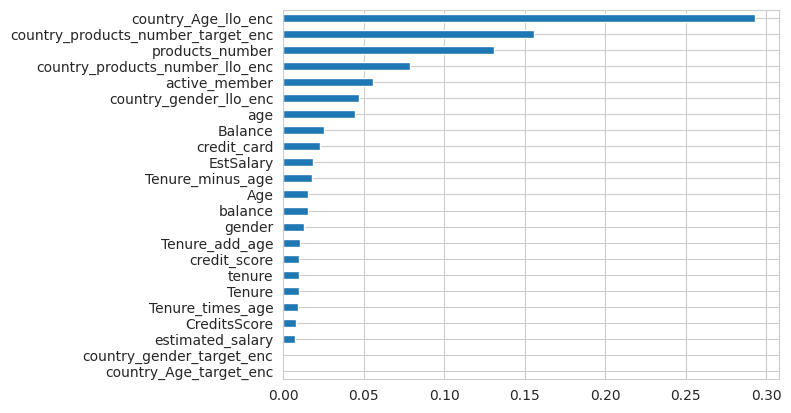

In [201]:
feat_importances = pd.Series(XGB_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

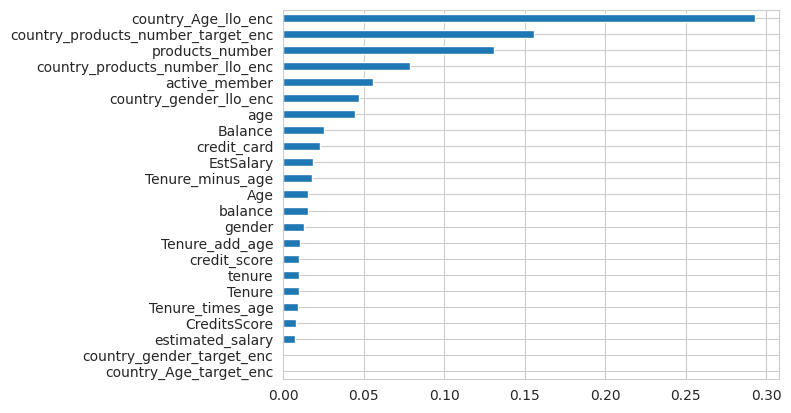

In [202]:
# loo,target
feat_importances = pd.Series(XGB_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

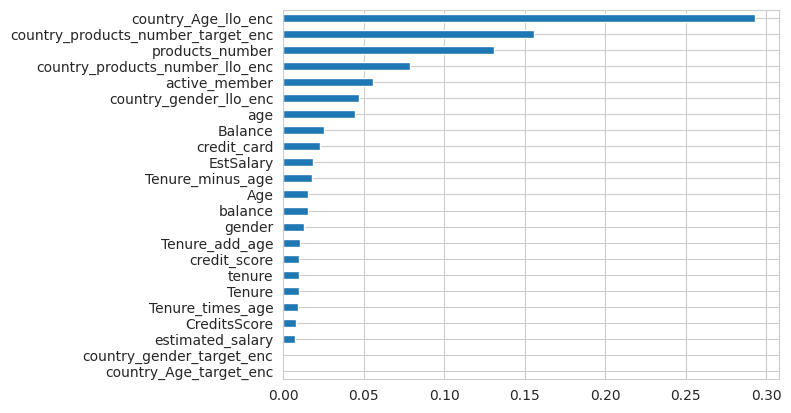

In [203]:
# loo,target
feat_importances = pd.Series(XGB_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

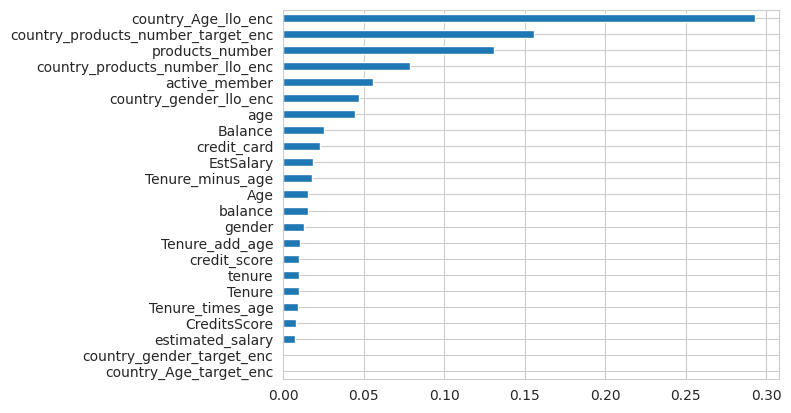

In [204]:
feat_importances = pd.Series(XGB_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

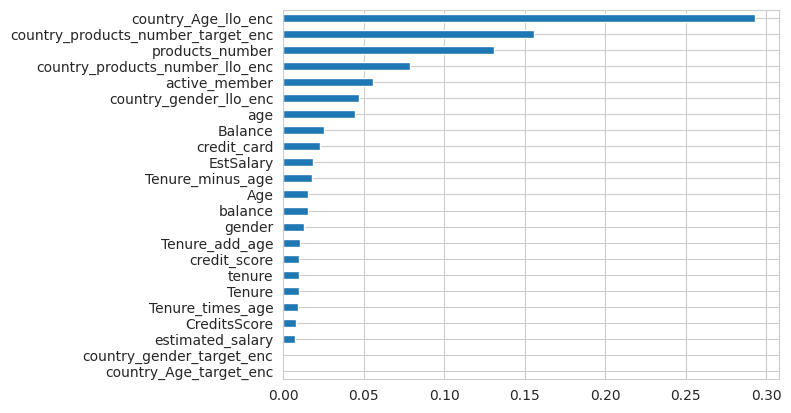

In [205]:
feat_importances = pd.Series(XGB_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

In [206]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

test Accuracy: 0.9481970543423057
test Recall: 0.943250214961307
test F1 score: 0.9555749128919862


In [207]:
# Banlance, Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

test Accuracy: 0.9481970543423057
test Recall: 0.943250214961307
test F1 score: 0.9555749128919862


In [208]:
from keras.models import Sequential
from keras.layers import Dense

In [209]:
# Create a neural network model
k_model = Sequential()
k_model.add(Dense(11, activation='relu', input_shape=(df.shape[1],)))
k_model.add(Dense(4, activation='relu'))
k_model.add(Dense(1, activation='sigmoid'))
k_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Create a Keras model
k_model = Sequential()
k_model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
k_model.add(Dense(32, activation='relu'))
k_model.add(Dense(1, activation='sigmoid'))
k_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training data
k_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10


In [ ]:
# Predict on the testing data
y_pred = k_model.predict(X_test)

# Convert the predictions to binary labels
y_pred = (y_pred > 0.4).astype(int)


In [ ]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

In [ ]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print('test Recall:', recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

Metrics
---

1. `Precision`: Precision is the ratio of true positives (TP) to the sum of true positives and false positives (FP):
Precision = TP / (TP + FP)

2. `Recall`: Recall is the ratio of true positives (TP) to the sum of true positives and false negatives (FN):
Recall = TP / (TP + FN)

3. `F1`-score: The F1-score is the harmonic mean of precision and recall:
$$F1 = 2  \frac{\text{Precision}\times \text{Recall}}{\text{Precision + Recall}}$$

In [ ]:
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
accuracy_score(y_test, y_pred)

In [ ]:
# loo, GLMM, target, country_products_number
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
accuracy_score(y_test, y_pred)

In [ ]:
# loo,  country_products_number
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
accuracy_score(y_test, y_pred)

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.summer):
    plt.clf
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=22)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(cnf_matrix, np.unique(y_pred))


In [ ]:
plot_confusion_matrix(cnf_matrix, np.unique(y_pred))

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 20)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = XGB_model, X = X_train, y = y_train, cv = 20)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = XGB_model, X = X_test, y = y_test, cv = 20)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Random Forest Classification, rfc
---
Set of week models

In [ ]:
rfc1= RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) # Pass hyperparameters

rfc1.fit(X_train, y_train)

In [ ]:
def plot_feature_importances(model):
    feat_importances = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
    feat_importances.plot(kind = 'barh');
    #plt.barh(range(n_features), model.feature_importances_, align='center')
    #plt.yticks(np.arange(n_features), X.columns)

In [ ]:
plot_feature_importances(rfc1)

In [ ]:
#Calculate the accuracy
y_pred = rfc1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('test Accuracy:', accuracy)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print('test F1 score:', f1)

In [ ]:
def score_model(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    #model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('test Accuracy:', accuracy)

    recall = recall_score(y_test, y_pred)
    print('test Recall:', recall)

    f1 = f1_score(y_test, y_pred)
    print('test F1 score:', f1)

#score_model(rfc1)

In [ ]:
score_model(XGB_model)

In [ ]:
rfc2= RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=42) # Pass hyperparameters
rfc2.fit(X_train, y_train)

In [ ]:
score_model(rfc2)

In [ ]:
lgbm_model = LGBMClassifier(learning_rate = 0.07,
                        max_delta_step = 2,
                        n_estimators = 100,
                        max_depth = 10,
                        eval_metric = "logloss",
                        objective='binary',
                        random_state=42)
lgbm_model.fit(X_train, y_train)

In [ ]:
score_model(lgbm_model)

In [ ]:
from xgboost import XGBClassifier

XGB_model2 = XGBClassifier(
    learning_rate=0.07,
    max_delta_step=2,
    n_estimators=100,
    max_depth=10,
    eval_metric="logloss",
    objective="binary:logistic",
    random_state=42,
    n_jobs=-1,
    booster="gbtree",
    nthread=4,
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    missing=0,
    num_parallel_tree=1,
    predictor="auto",
    max_leaves=31,
    tree_method="hist",
    gpu_id=-1,
    enable_categorical=False,
    validate_parameters=True,
    disable_default_eval_metric=False,
    grow_policy="depthwise",
    max_bin=255,
    min_data_in_leaf=1,
    min_child_samples=20,
    max_depth_reduction=0,
    min_data_in_bin=1,
    min_gain_to_split=0,
    min_split_gain=0,
    min_split_loss=0,
    )

XGB_model2.fit(X_train, y_train)

In [ ]:
score_model(XGB_model2)

In [ ]:
score_model(XGB_model2)

In [ ]:
score_model(XGB_model2)

In [ ]:
ce.

In [ ]:
cat_model=CatBoostClassifier(learning_rate=0.03,silent=True)
cat_model.fit(X_train, y_train)

In [ ]:
score_model(cat_model)

In [ ]:
cfm = confusion_matrix(y_test, y_pred=cat_model.predict(X_test))
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='CatBoost Prediction')
tn, fp, fn, tp = cfm.ravel()

In [ ]:

plot_confusion_matrix(cfm, ['Non Churn','Churn'],title='Catboost')


Ensemble of Models
---

In [ ]:
list_of_models = {
    'logistic_regression' : LogisticRegression(random_state = 42, max_iter = 10000),
    'Random_forest' : RandomForestClassifier(n_estimators = 150, max_depth = 4, random_state = 42),
    "XGBoost" : xgb.XGBClassifier(n_estimators = 200, max_depth = 5, random_state = 42)
}

In [ ]:
f1_train_scores = []
f1_test_scores = []
recall_test_scores = []
model_names = list(list_of_models.keys())

In [ ]:
model_names

In [ ]:
for model in model_names:
    print("\nFor Model:", model)

    list_of_models[model].fit(X_train, y_train)

    print("\nFor Training Set:")

    y_train_pred = list_of_models[model].predict(X_train)

    f1_train = f1_score(y_train, y_train_pred, average='macro')
    print("\nMacro F1 Score:", f1_train)

    print("\nConfusion Matrix:")
    Confusion_Matrix = confusion_matrix(y_train.values, y_train_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = Confusion_Matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

    print("For Test Set:")

    y_test_pred = list_of_models[model].predict(X_test)

    f1_test = f1_score(y_test, y_test_pred, average='macro')
    print("\nMacro F1 Score:", f1_test)

    recall_test_score = recall_score(y_test, y_test_pred, average='macro')

    print("\nConfusion Matrix:")
    Confusion_Matrix = confusion_matrix(y_test, y_test_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = Confusion_Matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)
    recall_test_scores.append(recall_test_score)

In [ ]:
print("model_names           f1_train_scores  f1_test_scores   recall_test_scores")
for i in range(len(model_names)):
    print(f"{model_names[i]:<22} {f1_train_scores[i]:.6f}          {f1_test_scores[i]:.6f}.          {recall_test_scores[i]:.6f}")

In [ ]:
df_score=pd.DataFrame()
df_score['model']=model_names
df_score['f1_train_scores']=f1_train_scores
df_score['f1_test_scores']=f1_test_scores
df_score['recall_test_scores']=recall_test_scores
df_score

In [ ]:
# convert to table
from IPython.display import HTML
HTML(df_score.to_html())

In [ ]:
log_reg_model = LogisticRegression(random_state = 42, max_iter = 10000)
xgb_model = xgb.XGBClassifier(n_estimators = 200, max_depth = 5, random_state = 42)

#fit logistic regression model
log_reg_model.fit(X, y)
#fit xgb model
xgb_model.fit(X, y)

#predict using ensemble of both the models
y_pred_proba_log = [x[1] for x in log_reg_model.predict_proba(X)]
y_pred_proba_xgb = [x[1] for x in xgb_model.predict_proba(X)]
y_pred_proba_log = np.array(y_pred_proba_log)
y_pred_proba_xgb = np.array(y_pred_proba_xgb)

y_pred_proba = (y_pred_proba_log + y_pred_proba_xgb) / 2.0

y_pred = np.where(y_pred_proba > 0.4, 1, 0)




In [ ]:
f1 = f1_score(y, y_pred, average = 'macro')
print("\nMacro F1 Score:", f1)

recall = recall_score(y, y_pred, average = 'macro')
print("\nMacro Recall Score:", recall)

print("\nConfusion Matrix:")
Confusion_Matrix = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = Confusion_Matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
#Save and export models to be used in deployment
import pickle
#Save and export models to be used in deployment

pickle.dump(log_reg_model, open('churn_logistic_regression_model_for_deployment.pkl','wb'))
pickle.dump(xgb_model, open('churn_xgb_model_for_deployment.pkl','wb'))

In [ ]:
X.head(5)

In [ ]:
X.columns

Imbalance Problem
---
Gerenally, churn data is a little small such that affects the prediction. Here we can enlarge the churn dataset by simulation, and re-make the prediction model:

```python
X = df_data_model.loc[:, df_data_model.columns!=’churn’]
y = df_data_model[‘churn’]

# from imblearn.over_sampling import SMOTE
smote = SMOTE()
# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X,y)
print(‘Original dataset shape’, Counter(y))
print(‘Resample dataset shape’, Counter(y_smote))

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_smote, y_smote, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print(‘Train’, X_train.shape, y_train.shape)
print(‘Test’, X_valid.shape, y_valid.shape)

#adaboost model training
ada_clf = AdaBoostClassifier(random_state=0)
kfold = KFold(n_splits = 10, random_state = 5)
results = cross_val_score(ada_clf, X_train, y_train, cv = kfold)
print(results.mean())


#train model
ada_clf.fit(X_train, y_train)
#make predictions
y_pred = ada_clf.predict(X_valid)
#metrics
print('Model accuracy score: ',accuracy_score(y_valid,y_pred))
print('Confusion matrix: ')
print(confusion_matrix(y_valid,y_pred))
print(classification_report(y_valid,y_pred))
```

Appendix, Pycaret Review
---

In [ ]:
!pip install -U pycaret

In [ ]:
from pycaret.classification import *

In [ ]:
X['churn']=y

In [ ]:
X.head(2)

In [ ]:
clf = setup(data=X,target='churn',session_id=123)
best = compare_models()

In [ ]:
X.head(2)

Improvements
---
- Using SHAP to analyze the key factors driving churn predictions from the XGBoost model
- Identifying high-risk customers based on a probability threshold
- Implementing a function to regularly score the full customer base and save high-risk cases
- Setting up the scoring function to run as a recurring monthly job

In [ ]:
!pip install -q shap

In [ ]:
# Root Cause Analysis
import shap
import matplotlib.pyplot as plt

In [ ]:


# Load trained XGBoost model
xgb_model = pickle.load(open('churn_xgb_model.pkl', 'rb'))

# Sample customer data
customer_data = X.sample(100)

# Compute SHAP values to understand feature importance
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(customer_data)

# Visualize top factors driving churn predictions
shap.summary_plot(shap_values, customer_data, plot_type="bar")
plt.show()

# Churn Prevention
# Identify high-risk customers based on churn probability threshold
from sklearn.metrics import roc_curve

# Compute probability predictions
y_prob = xgb_model.predict_proba(X)[:,1]

# Compute false positive and true positive rates
fpr, tpr, thresholds = roc_curve(y, y_prob)

# Find threshold for 80% tpr
tpr80 = 0.8
idx = np.argwhere(tpr >= tpr80)[0]
threshold = thresholds[idx]

# Customers above threshold are high-risk
high_risk_customers = X[y_prob >= threshold]

print(f"Number of high-risk customers: {len(high_risk_customers)}")

# Monitoring System
import datetime

# Score full customer base each month
def score_customer_base(date):
    customers = get_all_customers(date)
    customers = preprocess_data(customers)
    scores = xgb_model.predict_proba(customers)[:,1]
    high_risk = customers[scores >= threshold]

    # Save high-risk cases for further action
    high_risk.to_csv(f"high_risk_{date}.csv")

# Set up monitoring job to run monthly
next_run = datetime.datetime.today() + datetime.timedelta(days=30)
score_customer_base(next_run)

Homework
---
Whatever method was used, `Domain Expertise` is the the important factor where the decision was made.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# gdrive/MyDrive/2023/2023-2-Python-AI

In [ ]:
!ls gdrive/MyDrive/2023/2023-2-Python-AI/data

In [ ]:
# Very complainted in the second issue
import pandas as pd
df = pd.read_csv('gdrive/MyDrive/2023/2023-2-Python-AI/data/Consumer_Complaints.csv.zip')
df.head(2)

In [ ]:
df.info()

In [ ]:
# delete the feature which is absent too many items
df = df[pd.notnull(df['Consumer complaint narrative'])]
len(df)

In [ ]:
df = df[['Product', 'Consumer complaint narrative']]
df['category_id'] = df['Product'].factorize()[0]
df.head(5)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df['Consumer complaint narrative']).toarray()
labels = df.category_id
features.shape

In [ ]:
import gc
gc.collect()

In [ ]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [ ]:
# failed, scikit-learn 1.2.2
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

In [ ]:
import numpy as np
from scipy.stats import beta

class BetaTargetEncoder:
    def __init__(self):
        self.encoder = {}

    def fit(self, X, y):
        for i, category in enumerate(np.unique(X)):
            category_values = X[X == category]
            target_values = y[X == category]
            self.encoder[category] = beta.fit(target_values, [len(target_values), len(target_values) - len(target_values)])

    def transform(self, X):
        encoded_values = []
        for category in np.unique(X):
            category_values = X[X == category]
            encoded_values.append(self.encoder[category].sf(category_values))
        return np.array(encoded_values).T

# Example usage:
import numpy as np
from scipy.stats import beta

class BetaTargetEncoder:
    def __init__(self):
        self.encoder = {}

    def fit(self, X, y):
        for i, category in enumerate(np.unique(X)):
            category_values = X[X == category]
            target_values = y[X == category]
            self.encoder[category] = beta.fit(target_values, [len(target_values), len(target_values) - len(target_values)])

    def transform(self, X):
        encoded_values = []
        for category in np.unique(X):
            category_values = X[X == category]
            encoded_values.append(self.encoder[category].sf(category_values))
        return np.array(encoded_values).T

# Example usage:
X2 = np.array(['A', 'A', 'B', 'B', 'B', 'C', 'C', 'C'])
y2 = np.array([1, 2, 3, 4, 5, 6, 7, 8])

bte = BetaTargetEncoder()
bte.fit(X2, y2)
encoded = bte.transform(X2)
print(encoded)




Appendix
---
1. Hyperparmeter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


In [ ]:
xgb3 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
folds = 3
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
random_search = RandomizedSearchCV(xgb, param_distributions=params, \
                                   n_iter=param_comb, scoring='accuracy',\
                                   n_jobs=4,
                                   cv=skf.split(X_train,y_train),
                                   verbose=3, random_state=42 )

In [ ]:
random_search.fit(X_train,y_train)


In [ ]:
print(random_search.best_score_)


In [ ]:
from pprint import pprint
pprint(random_search.best_estimator_.get_params())